<a href="https://colab.research.google.com/github/fmathews11/College_Basketball_Functions/blob/main/Pulling_In_Boxscores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from bs4 import BeautifulSoup
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, warnings, time, requests, pandas as pd
warnings.filterwarnings("ignore")
from google.colab import output

In [2]:
class CustomError(Exception):
  pass

ids = pd.read_csv('https://raw.githubusercontent.com/fmathews11/College_Basketball_Functions/main/ids.csv')
convert_dict = {'MIN':int,
               'OREB':int,
               'DREB':int,
               'REB':int,
               'AST':int,
               'STL':int,
               'BLK':int,
               'TO':int,
               'PF':int,
               'PTS':int,
               'FGM':int,
               'FGA':int,
               '3PM':int,
               '3PA':int,
               'FTM':int,
               'FTA':int}
col_order = ['Player',
                 'PTS',
                 'MIN',
                 'FGM',
                 'FGA',
                 '3PM',
                 '3PA',
                 'FTM',
                 'FTA',
                 'OREB',
                 'DREB',
                 'REB',
                 'AST',
                 'STL',
                 'BLK',
                 'TO',
                 'PF',
                 'Position']

def calculate_possessions(fga,orebs,tos,fta):
    value = (fga-orebs) + tos + (0.475*fta)
    return value

def clean_up_boxscore(df):
    df = df.iloc[:len(df)-2,]
    df['Position'] = [i[-1] for i in df.Starters]
    df = df.infer_objects()
    df.Starters = [i[:int((len(i)-1)/2)] for i in df.Starters]
    df['FGM'] = [i[0] for i in df.FG.str.split('-')]
    df['FGA'] = [i[1] for i in df.FG.str.split('-')]
    df['3PM'] = [i[0] for i in df['3PT'].str.split('-')]
    df['3PA'] = [i[1] for i in df['3PT'].str.split('-')]
    df['FTM'] = [i[0] for i in df.FT.str.split('-')]
    df['FTA'] = [i[1] for i in df.FT.str.split('-')]
    if type(df.MIN[0]) == str:
      df.MIN = 0
    df = df.astype(convert_dict)
    df = df.append(df.sum(numeric_only = True),ignore_index = True)
    last_row = len(df) - 1
    df = df.rename(columns = {"Starters":"Player"})
    df = df[col_order]
    df.iloc[last_row,0] = 'Team'
    df.iloc[last_row,17] = ""
    df['PTS/FGA'] = round((df.PTS/df.FGA),2).fillna(0)

    final_col_order = ['Player',
                'PTS',
                'MIN',
                'FGM',
                'FGA',
                '3PM',
                '3PA',
                'FTM',
                'FTA',
                'OREB',
                'DREB',
                'REB',
                'AST',
                'STL',
                'BLK',
                'TO',
                'PF',
                'PTS/FGA',
                 'Position']
    return df.astype(convert_dict)[final_col_order]

def get_boxscores(game_id,disp = False):

  #Create the URL and pull in the HTML
  url = 'https://www.espn.com/mens-college-basketball/boxscore/_/gameId/'+str(game_id)
  r = requests.get(url)
  soup = BeautifulSoup(r.content,'lxml')

  #Isolate the home team, away team, and game date.  Away team is always first
  away_team = str(soup.find('title')).split('-')[0].replace("<title>","").strip().split(' vs. ')[0]
  home_team = str(soup.find('title')).split('-')[0].replace("<title>","").strip().split(' vs. ')[1]
  game_date = str(soup.find("title")).split("-")[2].strip()

  #Infer tables with Pandas
  dfs = pd.read_html(url)
  #Away team is always index value 1, home team is 2
  away_team_df = dfs[1]
  home_team_df = dfs[2]
  # Convert columns from tuples to strings
  if type(away_team_df.columns[0]) is tuple:
    away_team_df.columns = [i[0] for i in away_team_df.columns.tolist()]
  if type(home_team_df.columns[0]) is tuple:
    home_team_df.columns = [i[0] for i in home_team_df.columns.tolist()]

  #Clean the dataframes
  away_team_df = clean_up_boxscore(away_team_df)
  home_team_df = clean_up_boxscore(home_team_df)
  #Create outer index
  away_team_df = pd.concat({away_team:away_team_df})
  home_team_df = pd.concat({home_team:home_team_df})

  if disp:
    display(away_team_df,home_team_df)
  else:
    return away_team_df,home_team_df

def get_agg_boxscore(game_id,disp = True):
    try:
      df_away,df_home = get_boxscores(game_id)
    except:
      raise CustomError("Game Hasn't Started")
    away_team = df_away.index[0][0]
    home_team = df_home.index[0][0]
    last_row = len(df_away)
    df_away = df_away.iloc[last_row-1:]
    df_away = df_away[["PTS",
          "FGM",
          "FGA",
          "3PM",
          "3PA",
          "FTM",
          "FTA",
          "OREB",
          "DREB",
          "TO"]].reset_index().drop('level_1',1).rename(columns = {'level_0':'Team'}).set_index("Team")

    last_row = len(df_home)
    df_home = df_home.iloc[last_row-1:]
    df_home = df_home[["PTS",
          "FGM",
          "FGA",
          "3PM",
          "3PA",
          "FTM",
          "FTA",
          "OREB",
          "DREB",
          "TO"]].reset_index().drop('level_1',1).rename(columns = {'level_0':'Team'}).set_index("Team")
    away_team_dreb = df_away.DREB.item()
    home_team_dreb = df_home.DREB.item()
    df_home['OR%'] = 0
    df_away['OR%'] = 0
    if df_home.OREB.item() >0:
      df_home['OR%'] = 100*round(df_home.OREB.item()/(df_home.OREB.item() + away_team_dreb),2)
    if df_away.OREB.item() >0:
      df_away['OR%'] = 100*round(df_away.OREB.item()/(df_away.OREB.item() + home_team_dreb),2)
    final_df = pd.concat([df_away,df_home])

    final_df['POS'] = final_df.apply(lambda x: calculate_possessions(x.FGA,x.OREB,x.TO,x.FTA),axis = 1).astype(float).fillna(0)
    final_df['PTS_POS'] = round(final_df.PTS / final_df.POS,2).fillna(0)
    final_df['3PT%'] = 100*round(final_df['3PM'] / final_df['3PA'],2).fillna(0)
    final_df['FG%'] = 100*round(final_df.FGM/final_df.FGA,2).fillna(0)
    final_df["TS%"] = round(100*final_df.PTS/(2*(final_df.FGA + 0.475*final_df.FTA)),2).fillna(0)
    final_df['TO%'] = round(100*(final_df.TO/final_df.POS),2).fillna(0)
    final_df['POS'] = np.floor(final_df.POS).astype(int).fillna(0)
    type_dict = {'PTS':int,
                  'FGM':int,
                  'FGM':int,
                '3PM':int,
                '3PA':int,
                'FTM':int,
                'FTA':int,
                'OREB':int,
                'DREB':int,
                'TO':int,
                'POS':int}
    col_order = ['PTS',
                'FGM',
                'FGA',
                '3PM',
                '3PA',
                'FTM',
                'FTA',
                'OREB',
                'DREB',
                'TO',
                'POS',
                'PTS_POS',
                '3PT%',
                'FG%',
                'OR%',
                'TS%',
                'TO%']
    final_df = final_df[col_order]
    if disp:
      display(final_df.rename_axis("").astype(object).transpose())

    return final_df.astype(type_dict)

In [3]:
test_df = None
last_reported_time = 0

In [4]:
def plot_game_trends(test_df,half = 1,color1 = 'black',color2 = 'red'):
  melted = test_df.reset_index()
  for i in melted.columns.tolist()[:18]:
    plt.figure(figsize = (14,8))
    sns.lineplot(data = melted[melted.Half ==half].iloc[1:,:],
                x = 'Timestamp',
                y = i,
                hue = 'Team',
                palette = [color2,color1])
    plt.title(f"{melted.Team.tolist()[0]} vs {melted.Team.tolist()[1]}: {i.replace('_',' ')}")
    plt.ylabel(i.replace('_',' '))
    plt.xlabel('Time Remaining, 2nd Half')
    if half == 1:
      plt.xlabel('Time Remaining, 1st Half')
    plt.show();

In [9]:
def append_real_time_data(game_id,stats_df,disp = False):
  if disp:
    temp_df = get_agg_boxscore(401364432,disp = True)
  else:
    temp_df = get_agg_boxscore(401364432,disp = False)
  return pd.concat([stats_df,temp_df])

In [6]:
def get_game_timestamp_half(game_id):
  """
  Returns a tuple:
    [0]: The current timestamp of the half currently being played
    [1]: Which half is currently being played
  """
  url = "https://www.espn.com/mens-college-basketball/playbyplay/_/gameId/"
  url = url + str(game_id)

  half = 2
  all_dfs = pd.read_html(url)
  if np.isnan(all_dfs[0].iloc[0,2]):
    half = 1
  
  target_df = df = pd.read_html(url)[1]
  current_time = df.iloc[0,0]
  return current_time,half
get_game_timestamp_half(401364432)

('20:00', 2)

In [7]:
def scrape_game_stats_real_time(game_id,max_retries = 14,glob = True,disp = True):
  last_reported_timestamp = 0
  retry_iter = 0
  limbo_df = pd.DataFrame()

  if glob:
    global test_df
    while True:
      try:
        timestamp,half = get_game_timestamp_half(game_id)
      except:
        raise CustomError("Game hasn't started")
        break
      if timestamp != last_reported_timestamp:
        last_reported_timestamp = timestamp
        output.clear()
        temp_df = get_agg_boxscore(game_id = game_id,disp = True)
        temp_df['Half'] = half
        temp_df['Timestamp'] = timestamp
        test_df = pd.concat([test_df,temp_df])
        test_df.to_csv("test_df.csv")
        get_boxscores(game_id,disp = True)
        retry_iter = 0

        if disp:
          try:
            plot_game_trends(test_df,half = half,color1 = 'black',color2 = 'red')
          except:
            pass

        time.sleep(np.random.randint(10,20))
      else:
        retry_iter +=1
        if retry_iter > max_retries:
          break
        print(f"Retry number {retry_iter} of {max_retries}")
        time.sleep(np.random.randint(15,22))
       
      
  
  else:
    while True:
      try:
        timestamp,half = get_game_timestamp_half(game_id)
      except:
        raise Exception("Game hasn't started")
        break
      if timestamp != last_reported_timestamp:
        last_reported_timestamp = timestamp
        output.clear()
        temp_df = get_agg_boxscore(game_id = game_id,disp = True)
        temp_df['Half'] = half
        temp_df['Timestamp'] = timestamp
        limbo_df = pd.concat([limbo_df,temp_df])
        limbo_df.to_csv("limbo_df.csv")
        get_boxscores(game_id,disp = True)
        time.sleep(np.random.randint(10,20))
      else:
        retry_iter +=1
        if retry_iter == max_retries:
          break
        print(f"Retry number {retry_iter} of {max_retries}")
        time.sleep(np.random.randint(20,25))
    return limbo_df


In [8]:
test_df

,PTS,FGM,FGA,3PM,3PA,FTM,FTA,OREB,DREB,TO,POS,PTS_POS,3PT%,FG%,OR%,TS%,TO%
Team,,,,,,,,,,,,,,,,,
Illinois,68,24,58,8,26,12,15,7,19,9,67,1.01,31.0,41.0,24.0,52.21,13.41
Purdue,84,31,61,9,22,13,18,8,22,9,70,1.19,41.0,51.0,30.0,60.39,12.76


,Purdue,Wisconsin
PTS,67,70
FGM,24,26
FGA,56,61
3PM,8,7
3PA,21,22
FTM,11,11
FTA,20,12
OREB,8,7
DREB,26,23
TO,9,6


Player  PTS  MIN  FGM  FGA  ...  BLK  TO  PF  PTS/FGA  Position
Purdue 0      M. Gillis    5    0    2    4  ...    0   1   4     1.25         F
       1        Z. Edey   17    0    6   11  ...    1   0   3     1.55         C
       2        J. Ivey   22    0    8   15  ...    0   3   2     1.47         G
       3  E. Hunter Jr.    6    0    2    6  ...    0   2   3     1.00         G
       4  S. Stefanovic   11    0    4   10  ...    0   0   0     1.10         G
       5       C. Furst    0    0    0    1  ...    0   0   0     0.00         F
       6    T. Williams    6    0    2    8  ...    0   1   1     0.75         F
       7      E. Morton    0    0    0    1  ...    0   1   2     0.00         G
       8    I. Thompson    0    0    0    0  ...    0   1   1     0.00         G
       9           Team   67    0   24   56  ...    1   9  16     1.20          

[10 rows x 19 columns]

Player  PTS  MIN  FGM  FGA  ...  BLK  TO  PF  PTS/FGA  Position
Wisconsin 0    S. Crowl    4    0    2    6  ...    1   1   3     0.67         F
          1     T. Wahl   19    0    8   14  ...    2   1   1     1.36         F
          2  C. Hepburn   17    0    5   13  ...    0   0   4     1.31         G
          3  Joh. Davis   16    0    5   12  ...    0   3   3     1.33         G
          4  B. Davison    7    0    3    7  ...    0   0   2     1.00         G
          5  B. Carlson    2    0    1    2  ...    0   0   1     1.00         F
          6     C. Vogt    2    0    1    1  ...    1   1   1     2.00         C
          7  Jor. Davis    0    0    0    2  ...    0   0   2     0.00         G
          8    J. Neath    3    0    1    4  ...    0   0   0     0.75         G
          9        Team   70    0   26   61  ...    4   6  17     1.15          

[10 rows x 19 columns]

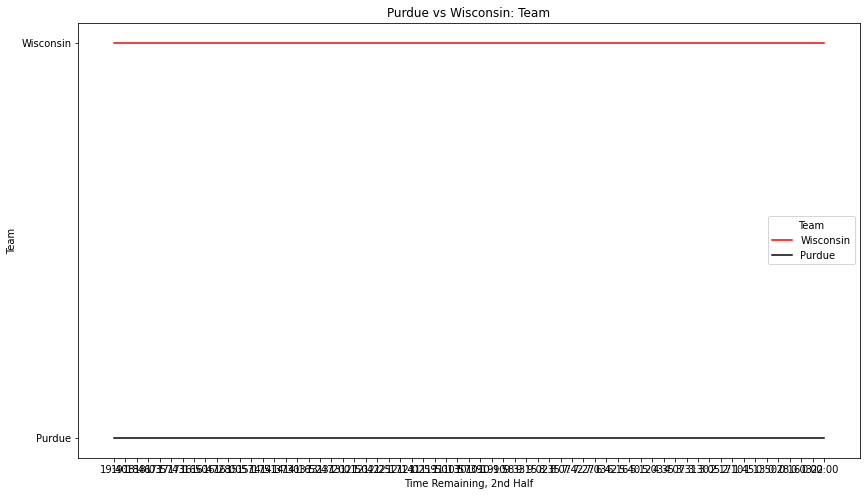

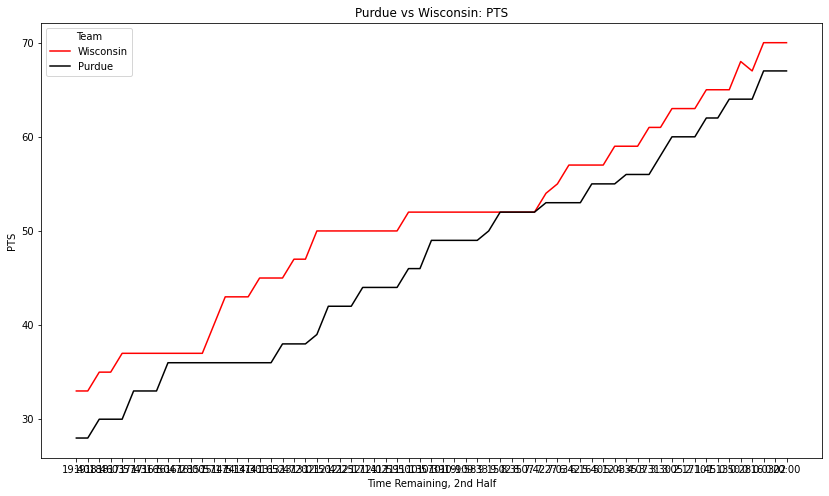

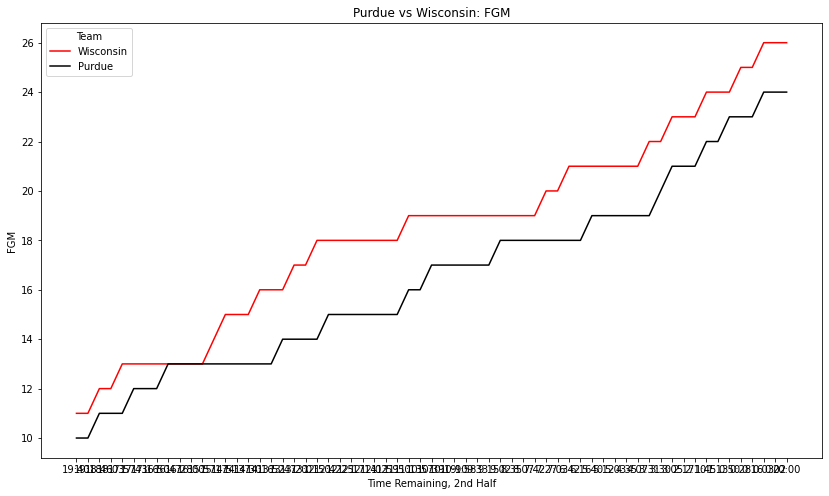

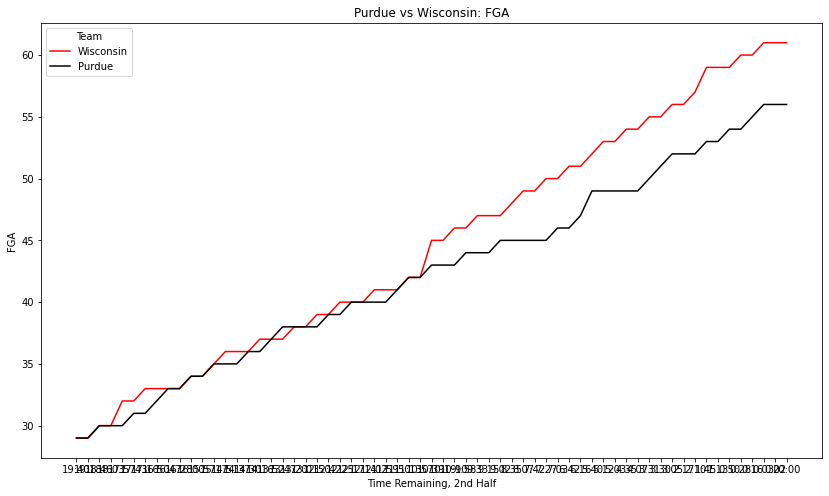

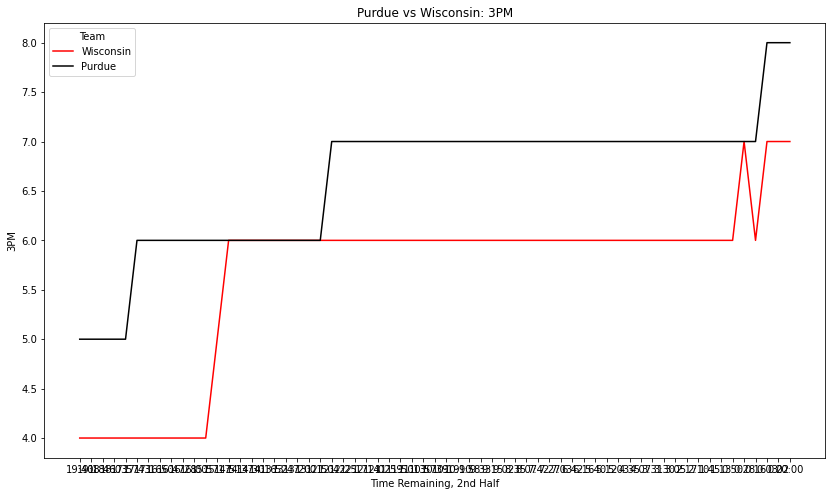

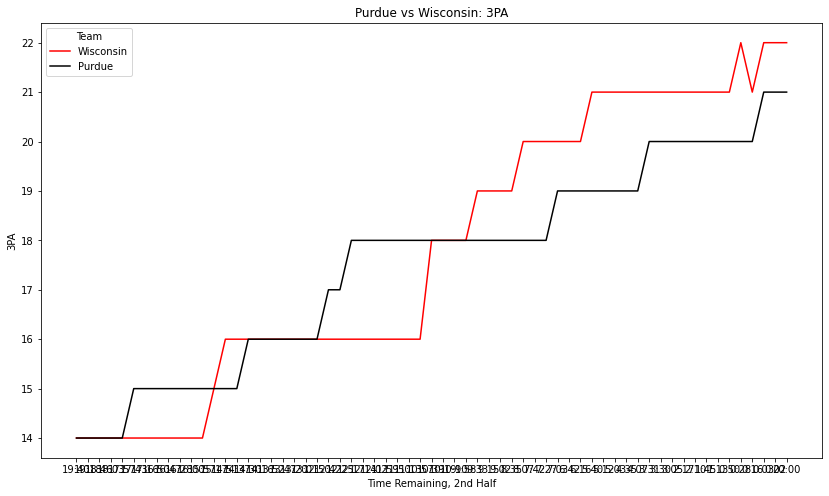

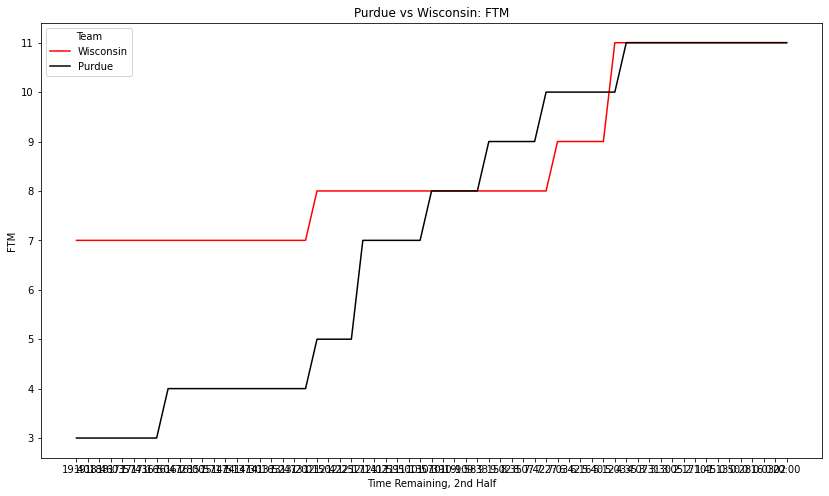

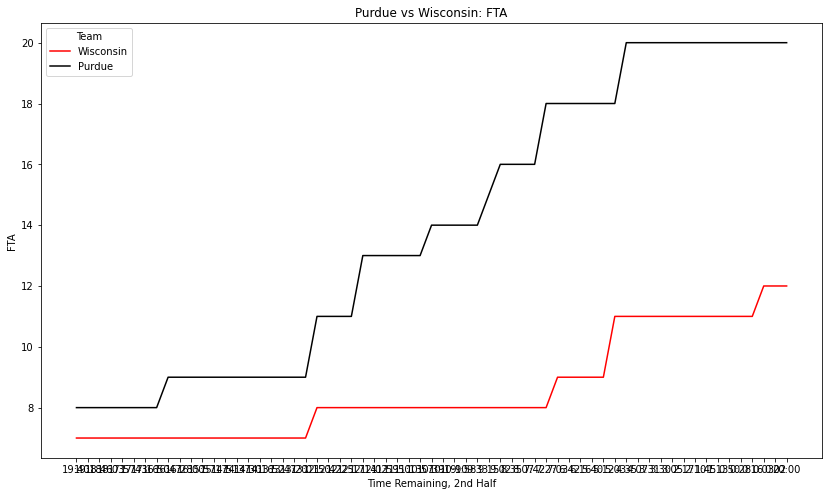

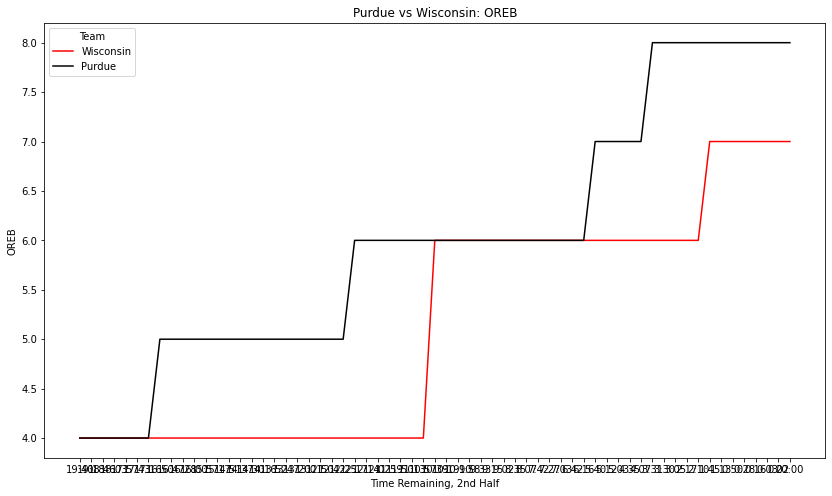

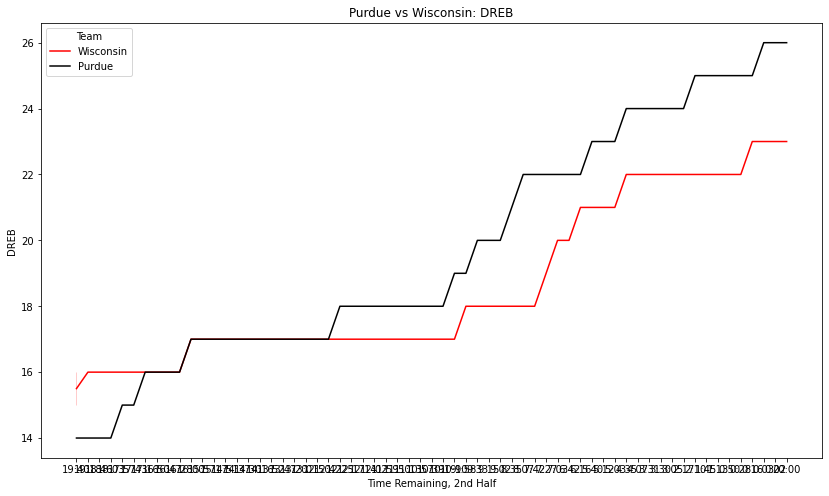

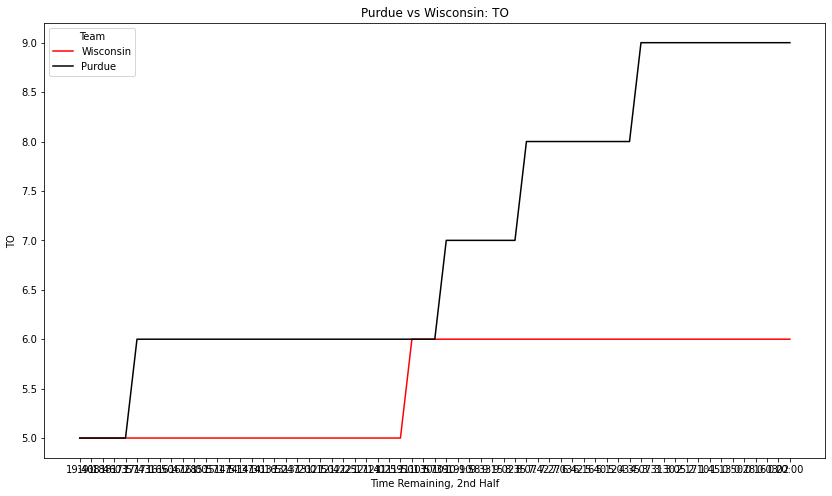

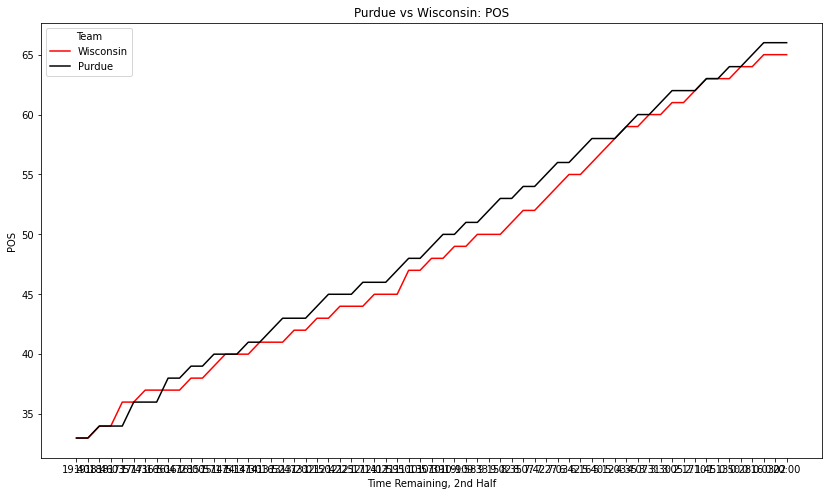

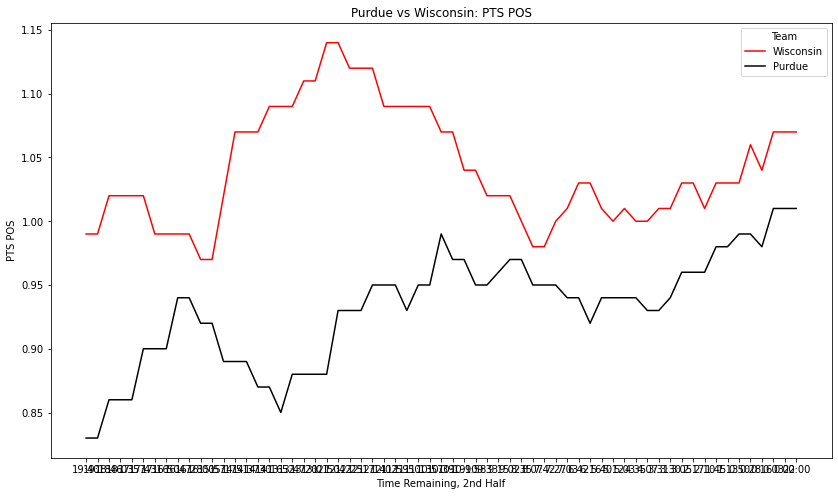

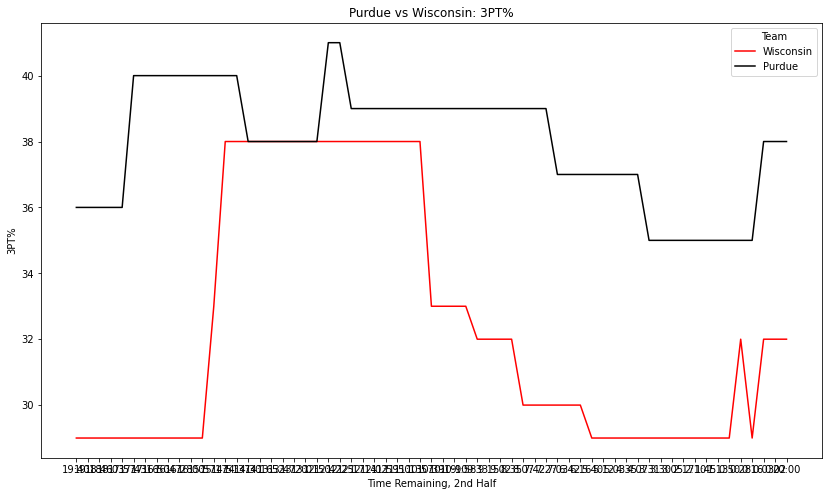

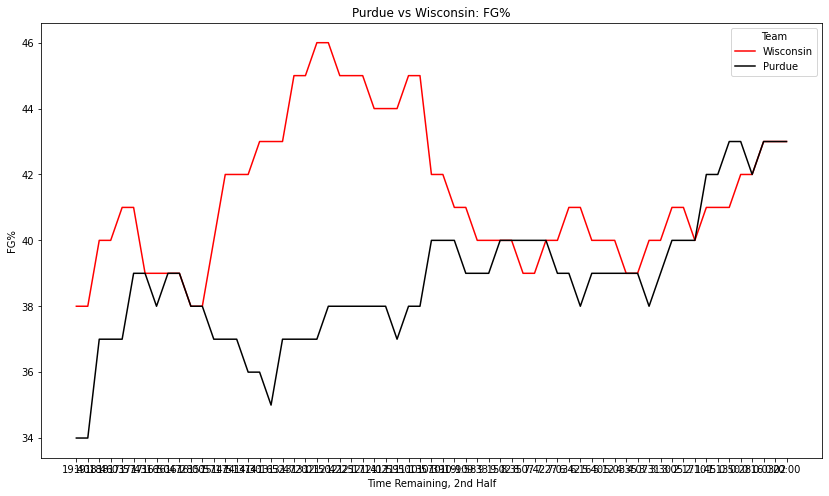

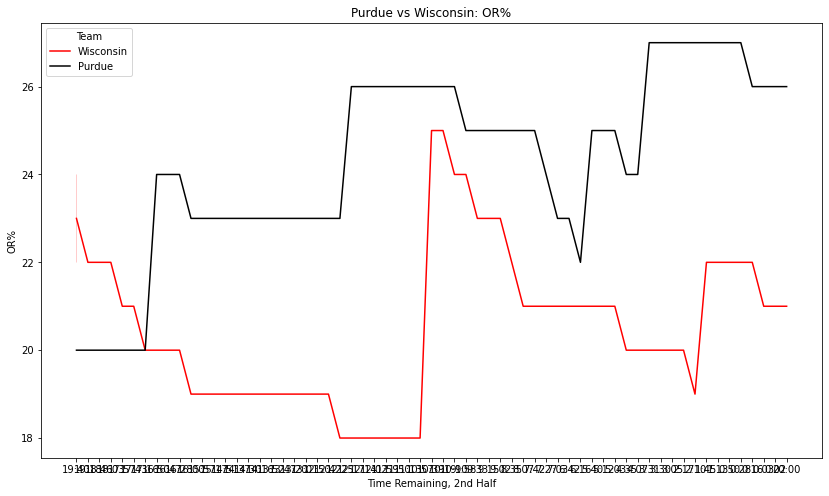

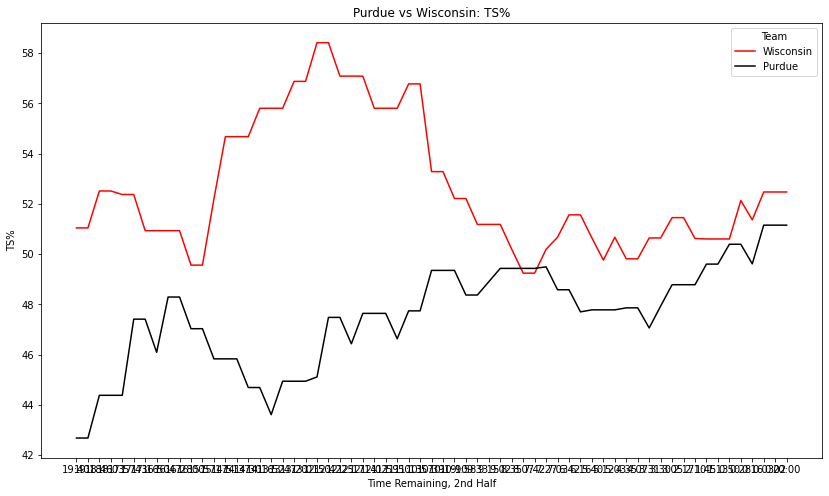

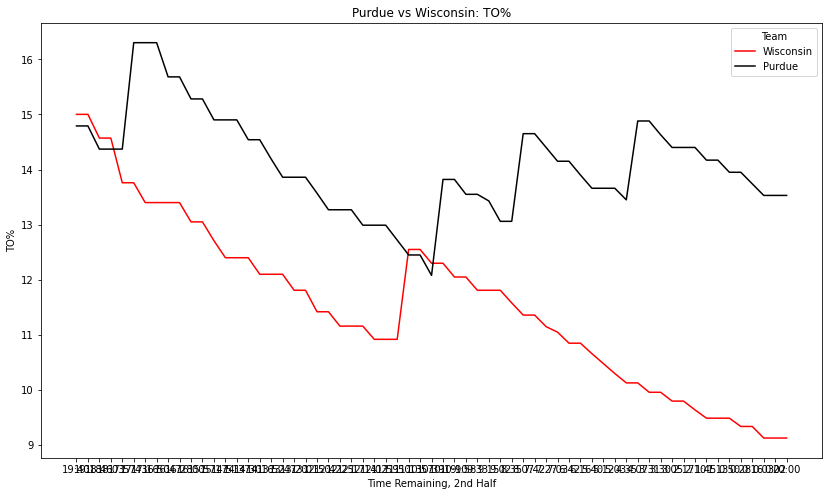

Retry number 1 of 14
Retry number 2 of 14
Retry number 3 of 14
Retry number 4 of 14


KeyboardInterrupt: ignored

In [ ]:
#test_df = pd.DataFrame()
scrape_game_stats_real_time(401364469,disp = True)
test_df

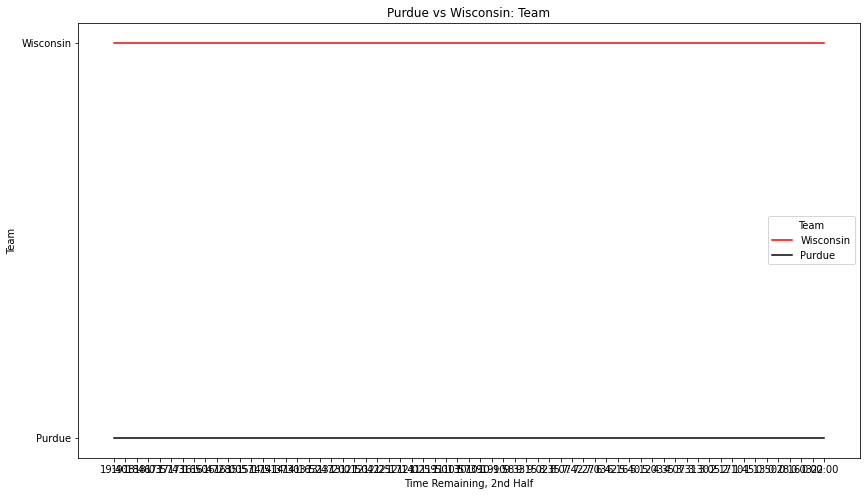

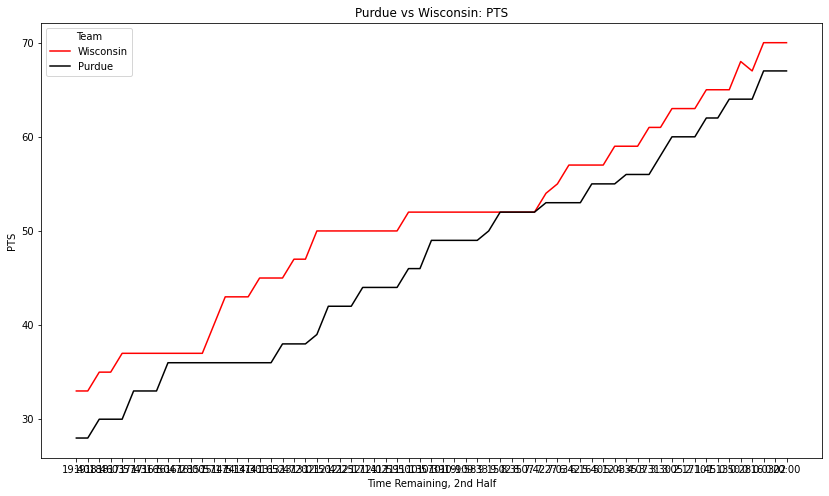

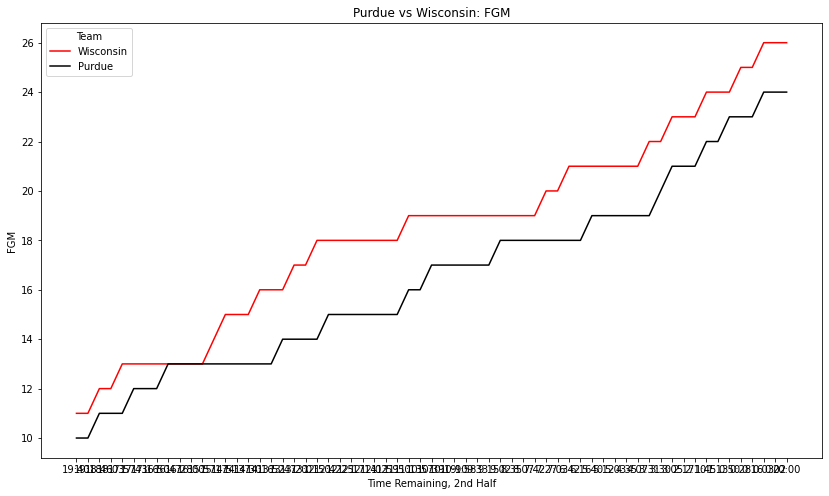

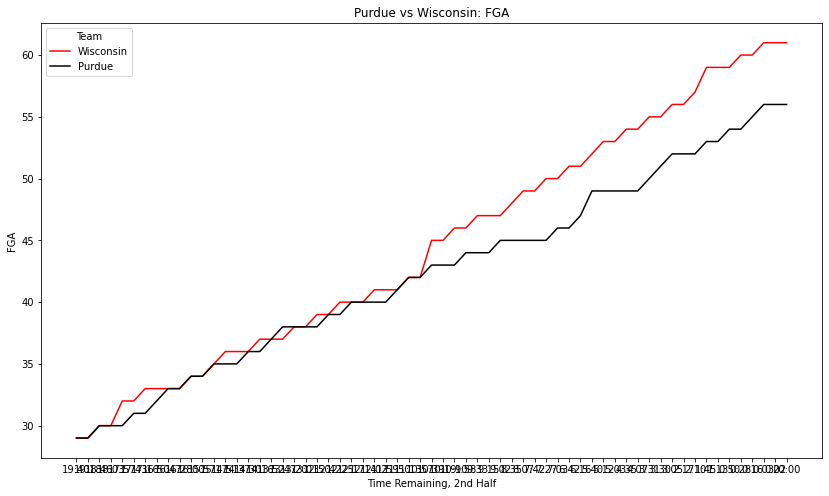

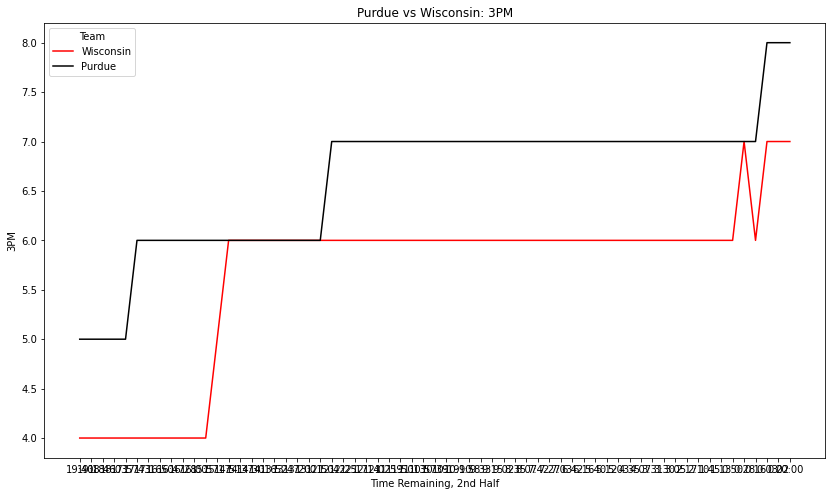

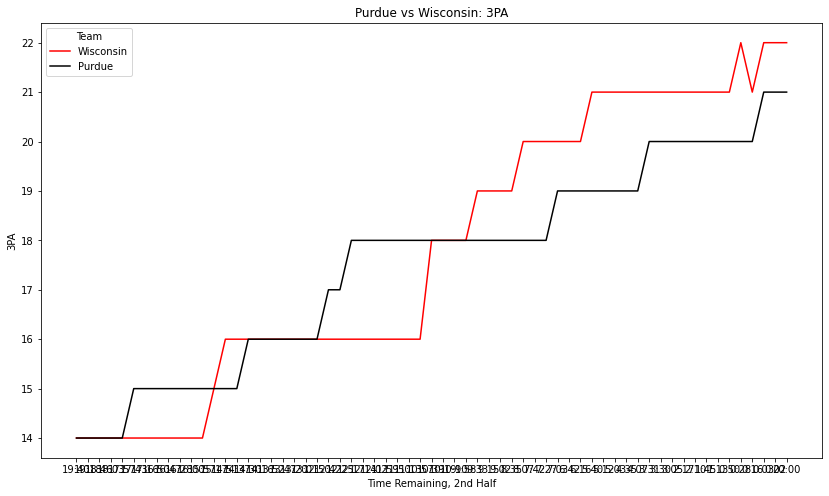

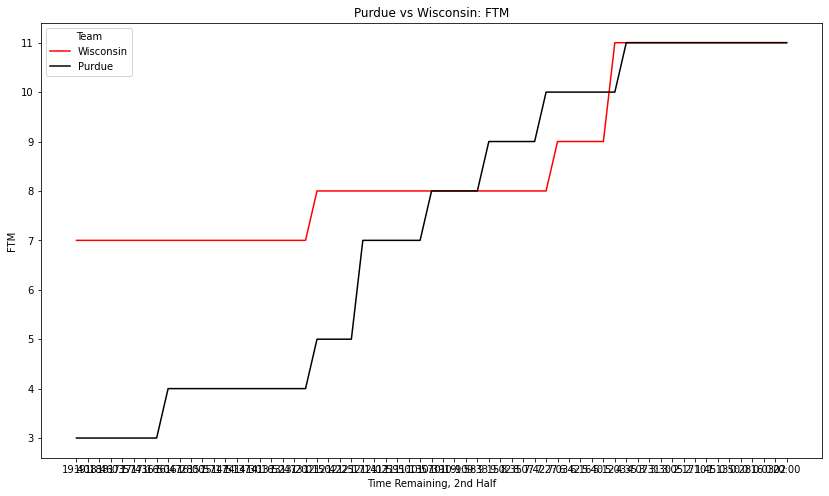

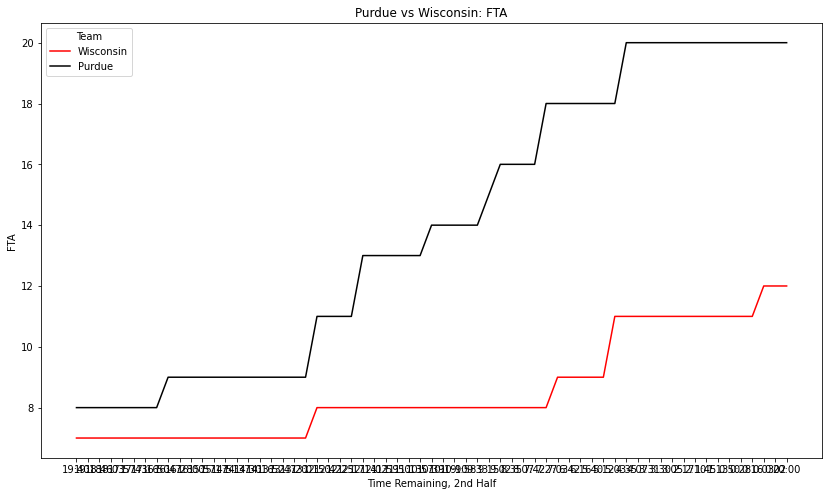

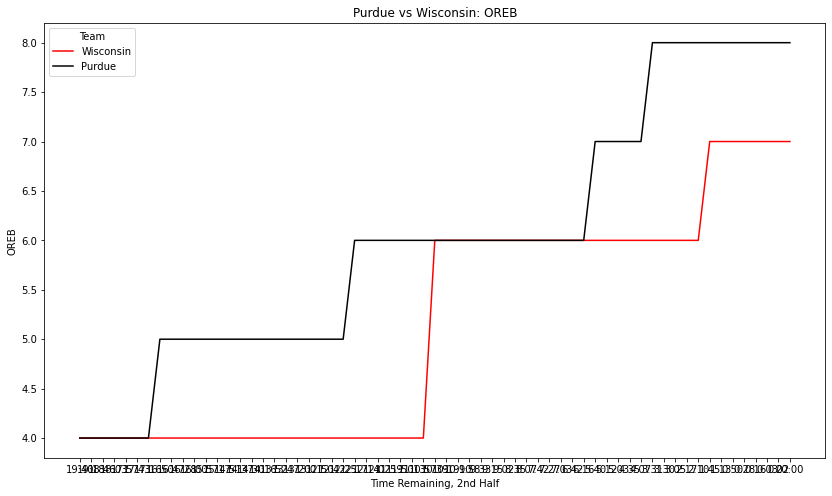

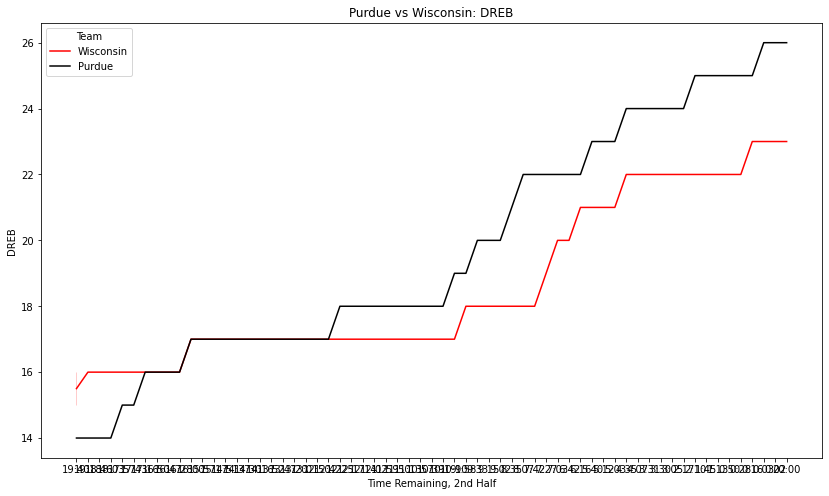

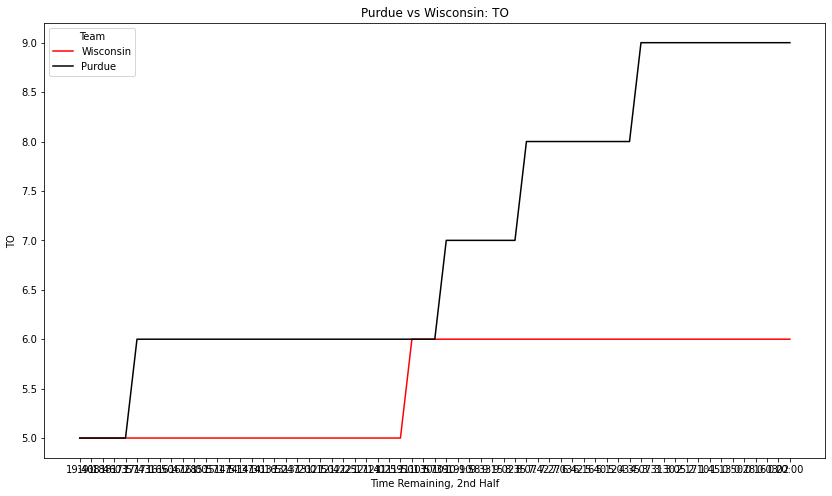

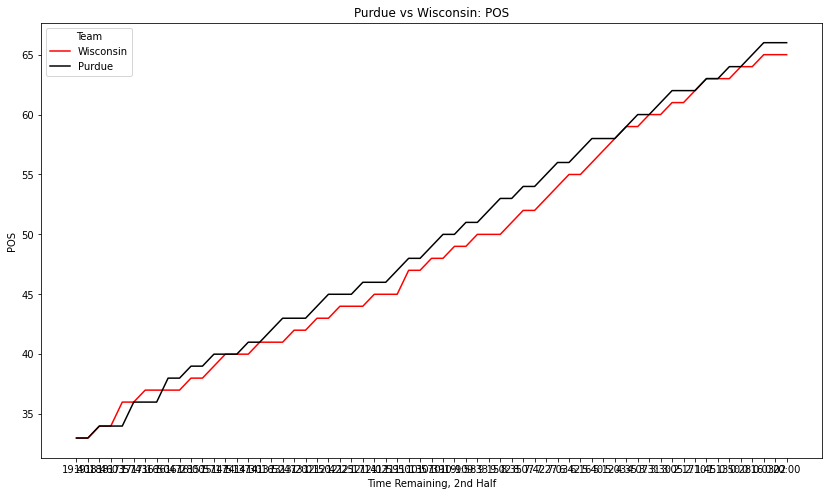

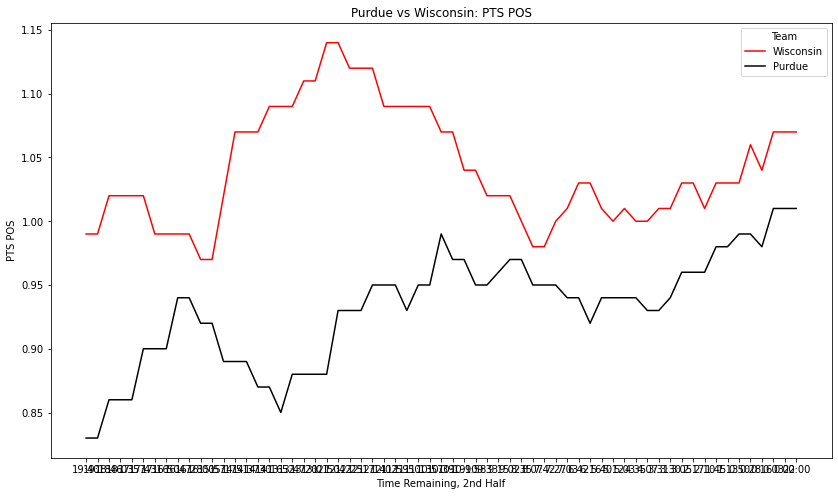

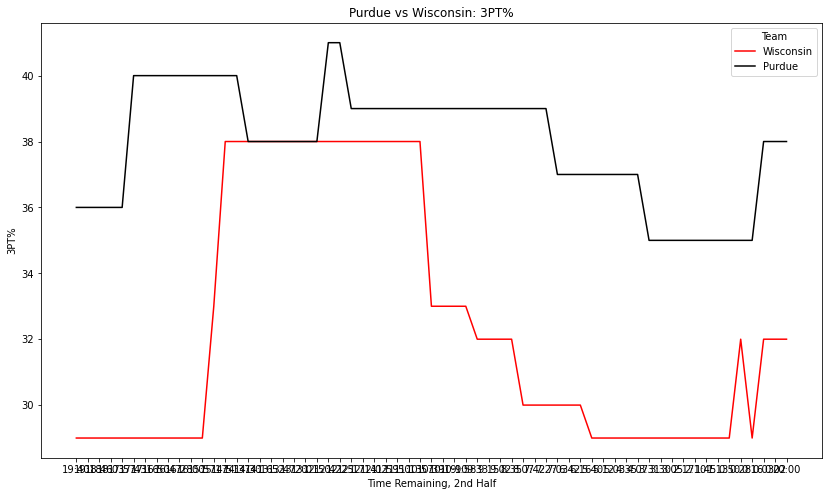

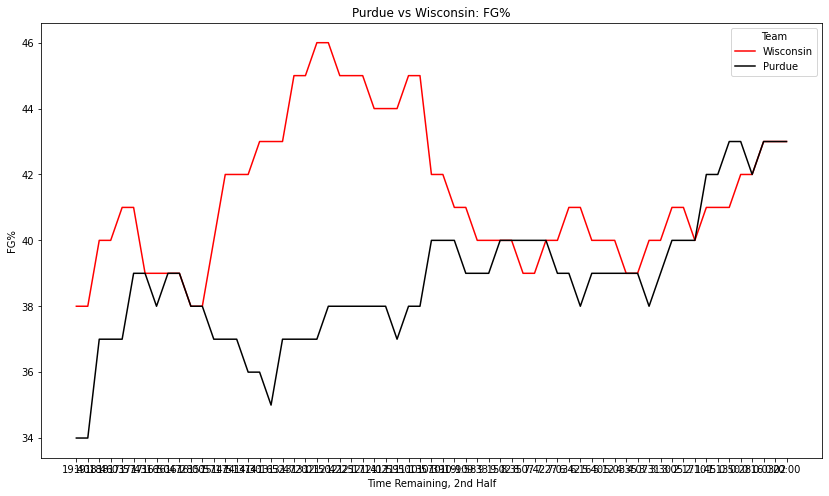

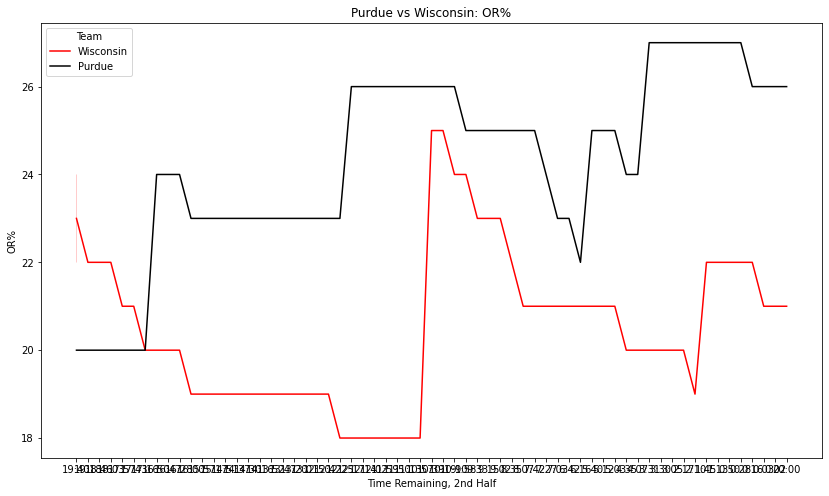

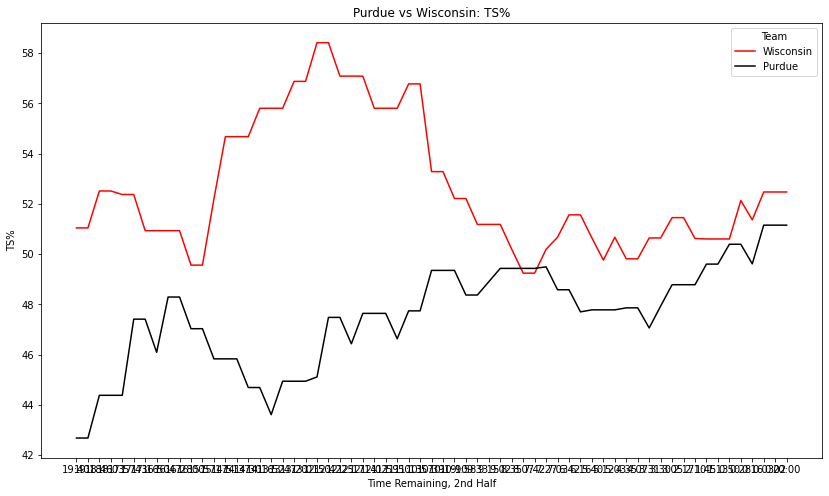

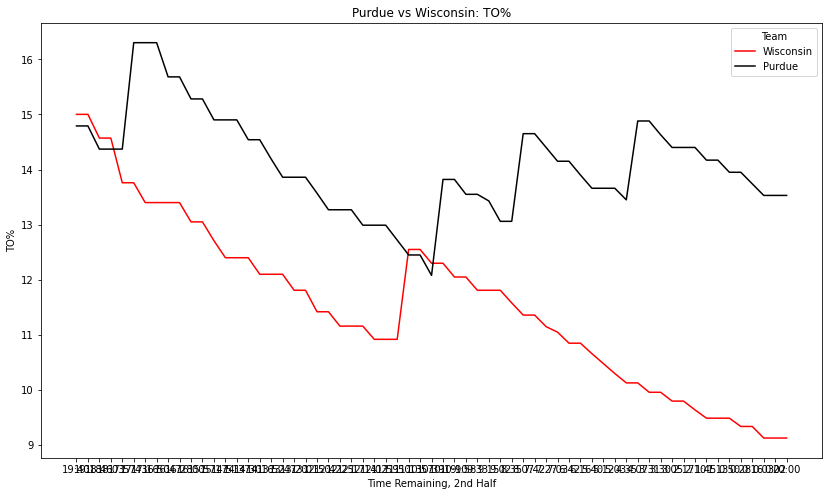

In [ ]:
plot_game_trends(test_df.drop_duplicates(),half = 2,color1='black',color2='red')